# Recommendation Systems Assignment

### MIE451/1513 UofT

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [1]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
import wget
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=879a9d37592a610a52933842feacbf55d3bf503259e1fa66635548c3d677f79e
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


## Support functions and variables

In [2]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"
# split data for cross_validation

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [3]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [0]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [0]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [6]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [7]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


## Q1

### (a)

In [0]:
def dataPreprocessor(rating_df, num_users, num_items):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########

    matrix = np.zeros((num_users, num_items), dtype=np.int8)
    
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating

    ###########         end         ###########
    return matrix

In [9]:
rating_matrix=dataPreprocessor(rating_df, num_users, num_items)
rating_matrix

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

### (b)

In [0]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros

        for (user,item), rating in np.ndenumerate(train_matrix):
          if rating == 0:
            userVector = train_matrix[user, :]
            ratedItems = userVector[userVector.nonzero()]
            if ratedItems.size == 0:
                itemAvg = 0
            else:
                itemAvg = ratedItems.mean()
            predictionMatrix[user, item] = itemAvg
          
          # if (user % 100 == 0 and item == 1):
          #   print ("calculated %d users" % (user,))
        ###########         end         ###########
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        itemPopularity = np.zeros((num_items))

        for item in range(num_items):
          numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
          numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
          if numOfUsersRated == 0:
              itemPopularity[item] = 0
          else:
              itemPopularity[item] = numOfUsersLiked/numOfUsersRated

        for (user,item), rating in np.ndenumerate(train_matrix):
        # Predict rating for every item that wasn't ranked by the user (rating == 0)
          if rating == 0:
              predictionMatrix[user, item] = itemPopularity[item]
                    
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [0]:
popularity_recsys = BaseLineRecSys('popularity')

In [0]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
x = popularity_recsys.getModel()

In [14]:
np.all(x<=1)

True

In [15]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [16]:
popularity_recsys.evaluate_test(rating_df,copy=True).head(10)

100000it [01:25, 1165.85it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0
5,298,474,4,884182806,0.0
6,115,265,2,881171488,0.0
7,253,465,5,891628467,0.0
8,305,451,3,886324817,0.0
9,6,86,3,883603013,0.0


In [0]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [0]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

In [19]:
average_user_rating_recsys.getModel()

array([[0.        , 0.        , 0.        , ..., 3.61029412, 3.61029412,
        3.61029412],
       [0.        , 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [0.        , 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 0.        , 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [20]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:25, 1166.96it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,0.0
1,186,302,3,891717742,0.0
2,22,377,1,878887116,0.0
3,244,51,2,880606923,0.0
4,166,346,1,886397596,0.0


## Q2

### (a)

In [0]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########
        distance_matrix=pairwise_distances(matrix, metric='euclidean')
        similarity_matrix=(1+distance_matrix)**-1
    
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
        distance_matrix=pairwise_distances(matrix, metric='manhattan')
        similarity_matrix=(1+distance_matrix)**-1
    
    
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            if self.method == 'cosine':
              uu_similarity = self.cosine(train_matrix)
            elif self.method == 'euclidean':
              uu_similarity = self.euclidean(train_matrix)
            else:
              uu_similarity = self.somethingelse(train_matrix)
            normalizer = np.matmul(uu_similarity, temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            useraverage=np.sum(train_matrix, axis=1)
            useraverage[useraverage!=0] = np.sum(train_matrix[useraverage!=0], axis=1)/np.sum(temp_matrix[useraverage!=0], axis=1)
            # useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model=predictionMatrix
            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            if self.method == 'cosine':
              ii_similarity = self.cosine(train_matrix.T)
            elif self.method == 'euclidean':
              ii_similarity = self.euclidean(train_matrix.T)
            else:
              ii_similarity = self.somethingelse(train_matrix.T)
            normalizer = np.matmul(temp_matrix,ii_similarity)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(train_matrix,ii_similarity)/normalizer
            useraverage=np.sum(train_matrix, axis=1)
            useraverage[useraverage!=0] = np.sum(train_matrix[useraverage!=0], axis=1)/np.sum(temp_matrix[useraverage!=0], axis=1)
            # useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model=predictionMatrix
            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [22]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [23]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [24]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

**Answer for Q2(a)**

Cosine similarity would be better since it's measured based on vector's angles which is unrelated with vector magnitude. This is suitable, because, consider the following example:
* User 1 gives rates [1,2,1] to movie 1,2,3
* User 2 gives rates [4,5,4] to movie 1,2,3
* User 3 gives rates [4,3,2] to movie 1,2,3
We want higher similarity between User 1 and 2 since they have same preference. That's what cosine captures. Alternatively, we will have higher similarity between User 2 and 3 if Euclidean is applied.

### (b)

**Answer for Q2(b)**

I selected Manhattan because it's similar to Euclidean. But in high dimension, Manhattan is more sensitive to small differences.

## Q3

### (a)

In [0]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [0]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [27]:
user_cosine_recsys.getModel()

array([[4.66462622, 3.01949578, 3.92768459, ..., 2.        , 3.        ,
        3.        ],
       [3.92370715, 3.16680464, 3.01003285, ..., 2.        , 3.        ,
        3.        ],
       [3.8438394 , 3.15747922, 3.04646849, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [4.34083471, 3.16245119, 3.08043971, ..., 2.        , 3.        ,
        3.        ],
       [3.85941289, 3.17820559, 3.02425528, ..., 2.        , 3.        ,
        3.        ],
       [3.87086043, 4.76318914, 3.04843709, ..., 2.        , 3.        ,
        3.        ]])

In [28]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:38, 1019.20it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,3.275595
1,186,302,3,891717742,3.416114
2,22,377,1,878887116,1.016091
3,244,51,2,880606923,2.094910
4,166,346,1,886397596,1.847146


In [0]:
item_cosine_recsys = SimBasedRecSys('item','cosine')

In [0]:
item_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [31]:
item_cosine_recsys.getModel()

array([[4.80122564, 3.13216694, 3.79721291, ..., 2.84230485, 2.86425045,
        2.86640424],
       [3.9899342 , 3.55801456, 3.50842658, ..., 2.41852891, 2.47951902,
        2.47946198],
       [2.80144051, 2.75470869, 2.72273922, ..., 2.39131613, 2.40137107,
        2.3928973 ],
       ...,
       [4.98660473, 3.98916246, 3.96778469, ..., 3.97457714, 3.97351684,
        3.9753824 ],
       [4.29696607, 4.24998433, 4.20384942, ..., 4.09940897, 4.10234751,
        4.10255168],
       [3.41995748, 4.60764353, 3.22497164, ..., 3.07776465, 3.08161949,
        3.08100621]])

In [32]:
item_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:25, 1168.61it/s]


,userID,itemID,rating,timestamp,item-cosine
0,196,242,3,881250949,3.025268
1,186,302,3,891717742,3.024428
2,22,377,1,878887116,1.459270
3,244,51,2,880606923,2.512328
4,166,346,1,886397596,1.061067


### (b)

In [0]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [0]:
# How to use CrossValidation Class?

In [0]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [item_cosine_recsys, 
                       user_cosine_recsys]

In [0]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Precision at K in this example
cv_RMSE = CrossValidation('RMSE')

In [37]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
RMSE=cv_RMSE.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm item-cosine


20000it [00:09, 2156.18it/s]
20000it [00:09, 2158.71it/s]
20000it [00:09, 2155.98it/s]
20000it [00:09, 2139.00it/s]
20000it [00:09, 2127.58it/s]


Processing algorithm user-cosine


20000it [00:09, 2142.14it/s]
20000it [00:09, 2168.78it/s]
20000it [00:09, 2135.18it/s]
20000it [00:09, 2147.94it/s]
20000it [00:09, 2163.67it/s]


In [0]:
score_df=pd.DataFrame(RMSE,index=['fold scores','mean','ci_low','ci_high'])

In [39]:
score_df

,item-cosine,user-cosine
fold scores,"[1.0391471011233044, 1.0268624430068984, 1.016...","[1.0318272790857639, 1.0267713155351685, 1.017..."
mean,1.02348,1.02232
ci_low,1.01137,1.01359
ci_high,1.03559,1.03104


In [40]:
rating_matrix.shape

(943, 1682)

In [41]:
# average rating percentage given by a user
np.count_nonzero(rating_matrix,axis=1).mean()

106.04453870625663

In [42]:
# average rating percent received by an item
np.count_nonzero(rating_matrix,axis=0).mean()

59.45303210463734

**Answer for Q3(b)**

Overall, those two methods perform almost equally well. However, in reality when working with higher dimensional data, the item-item method should prevail. Because the user-user method usually suffers from sparsity issue (most users only rate a few items). In this case, user-user method would not achieve accurate prediction from a few similar users.

## Q4

### (a)

In [0]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        ########### your code goes here ###########
    
        self.w_Item = None  # item M x D 
        self.w_User = None  # user N x D 
        self.w_Item=np.random.randn(num_item,self.num_feat)*0.1
        self.w_User=np.random.randn(num_user,self.num_feat)*0.1
    
        ###########         end         ###########  

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Compute mean rating subtracted rating  
                ########### your code goes here ###########
            
                pred_out = None #size (batch_size, )
                users=self.w_User[batch_UserID]
                items=self.w_Item[batch_ItemID]
                pred_out=np.sum(users*items,axis=1)
                # print(users.shape)
                # print(items.shape)
                # print((users*items).shape)
            
                ###########         end         ########### 
                # print(pred_out.shape)
                # print(self.mean_rating_train)
                # print(train_vec[shuffled_order[batch_idx], 2].shape)
                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = None # size(pairs_train, )
                    # train_UserID = np.array(train_vec[shuffled_order[train_user_idx], 0], dtype='int32')
                    # train_ItemID = np.array(train_vec[shuffled_order[train_item_idx], 1], dtype='int32')
                    train_users=self.w_User[train_user_idx]
                    train_items=self.w_Item[train_item_idx]
                    pred_out=np.sum(train_users*train_items,axis=1)
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    pred_out = None #size(pairs_val, )
                    # Shuffle training truples
                    # shuffled_order_val = np.arange(val_vec.shape[0])  
                    # np.random.shuffle(shuffled_order_val)  #shuffled
                    # val_UserID = np.array(val_vec[shuffled_order_val[val_user_idx], 0], dtype='int32')
                    # val_ItemID = np.array(val_vec[shuffled_order_val[val_item_idx], 1], dtype='int32')
                    val_users=self.w_User[val_user_idx]
                    val_items=self.w_Item[val_item_idx]
                    pred_out=np.sum(val_users*val_items,axis=1)
            
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))


        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)

In [0]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 18, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})

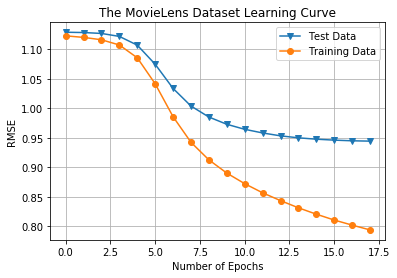

In [45]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

**Answer for Q4(b)**

The best maxepoch is 18

## Q5

### (a)

In [0]:
# 1. gather your algorithms in previous steps.
algorithm_instances = [popularity_recsys, 
                       average_user_rating_recsys, 
                       user_cosine_recsys,
                       pmf]

In [0]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Precision at K in this example
cv_rmse=CrossValidation('RMSE')
cv_patk = CrossValidation('P@K')
cv_ratk=CrossValidation('R@K')

In [48]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
RMSE=cv_rmse.run(algorithm_instances, num_users, num_items,k=10)
patk=cv_patk.run(algorithm_instances, num_users, num_items,k=10)
ratk=cv_ratk.run(algorithm_instances, num_users, num_items,k=10)

Processing algorithm popularity


20000it [00:09, 2105.59it/s]
20000it [00:09, 2127.97it/s]
20000it [00:09, 2201.56it/s]
20000it [00:09, 2200.63it/s]
20000it [00:09, 2138.90it/s]


Processing algorithm useraverage


20000it [00:09, 2072.45it/s]
20000it [00:09, 2155.89it/s]
20000it [00:09, 2181.00it/s]
20000it [00:09, 2128.87it/s]
20000it [00:09, 2140.41it/s]


Processing algorithm user-cosine


20000it [00:09, 2155.48it/s]
20000it [00:09, 2174.00it/s]
20000it [00:09, 2142.05it/s]
20000it [00:09, 2146.83it/s]
20000it [00:09, 2114.05it/s]


Processing algorithm PMF


20000it [00:16, 1204.05it/s]
20000it [00:16, 1213.98it/s]
20000it [00:16, 1218.29it/s]
20000it [00:16, 1195.44it/s]
20000it [00:16, 1183.59it/s]


Processing algorithm popularity


20000it [00:09, 2154.57it/s]
20000it [00:09, 2146.73it/s]
20000it [00:09, 2162.87it/s]
20000it [00:09, 2148.91it/s]
20000it [00:09, 2164.06it/s]


Processing algorithm useraverage


20000it [00:09, 2104.26it/s]
20000it [00:09, 2156.00it/s]
20000it [00:09, 2145.94it/s]
20000it [00:09, 2170.90it/s]
20000it [00:09, 2177.47it/s]


Processing algorithm user-cosine


20000it [00:09, 2128.29it/s]
20000it [00:09, 2165.34it/s]
20000it [00:09, 2173.17it/s]
20000it [00:09, 2166.41it/s]
20000it [00:09, 2143.98it/s]


Processing algorithm PMF


20000it [00:16, 1213.80it/s]
20000it [00:16, 1193.55it/s]
20000it [00:16, 1210.94it/s]
20000it [00:16, 1205.95it/s]
20000it [00:16, 1225.79it/s]


Processing algorithm popularity


20000it [00:09, 2136.10it/s]
20000it [00:09, 2151.37it/s]
20000it [00:09, 2165.44it/s]
20000it [00:09, 2167.62it/s]
20000it [00:09, 2159.89it/s]


Processing algorithm useraverage


20000it [00:09, 2138.88it/s]
20000it [00:09, 2156.08it/s]
20000it [00:09, 2166.13it/s]
20000it [00:09, 2172.00it/s]
20000it [00:09, 2123.27it/s]


Processing algorithm user-cosine


20000it [00:09, 2179.23it/s]
20000it [00:09, 2162.19it/s]
20000it [00:09, 2169.00it/s]
20000it [00:09, 2155.41it/s]
20000it [00:09, 2177.00it/s]


Processing algorithm PMF


20000it [00:16, 1228.63it/s]
20000it [00:16, 1217.23it/s]
20000it [00:16, 1213.83it/s]
20000it [00:16, 1216.45it/s]
20000it [00:16, 1222.91it/s]


In [0]:
RMSE_df=pd.DataFrame(RMSE,index=['fold scores','mean','ci_low','ci_high'])
patk_df=pd.DataFrame(patk,index=['fold scores','mean','ci_low','ci_high'])
ratk_df=pd.DataFrame(ratk,index=['fold scores','mean','ci_low','ci_high'])

In [50]:
RMSE_df

,popularity,useraverage,user-cosine,PMF
fold scores,"[3.177941281084362, 3.1750480150769977, 3.1474...","[1.0629951276561334, 1.0467467492319966, 1.032...","[1.0318272790857639, 1.0267713155351685, 1.017...","[0.9819839160202296, 0.9722159817714979, 0.958..."
mean,3.15909,1.04372,1.02232,0.965978
ci_low,3.13929,1.02893,1.01359,0.952072
ci_high,3.17889,1.0585,1.03104,0.979884


In [51]:
patk_df

,popularity,useraverage,user-cosine,PMF
fold scores,"[0.3355249204665964, 0.43679745493107086, 0.50...","[0.28801696712619335, 0.38759278897136823, 0.4...","[0.3373276776246028, 0.43966065747614, 0.50986...","[0.3339342523860025, 0.4340402969247085, 0.511..."
mean,0.463224,0.412471,0.464984,0.462524
ci_low,0.364723,0.316878,0.366848,0.362902
ci_high,0.561725,0.508064,0.563121,0.562145


In [52]:
ratk_df

,popularity,useraverage,user-cosine,PMF
fold scores,"[0.5431333642233128, 0.6353156908807237, 0.711...","[0.5036690558291653, 0.6041988801597493, 0.675...","[0.5462243530615339, 0.6405270955229735, 0.712...","[0.5396289516023431, 0.6332816647232149, 0.711..."
mean,0.676032,0.640924,0.678013,0.674588
ci_low,0.568189,0.531297,0.572151,0.565174
ci_high,0.783876,0.75055,0.783875,0.784002


### (b)

**Answer for Q5(b)**

Evaluate popularity prediction with RMSE does not make sense. Because the elements in popularity prediction matrix are all ranged in 0 to 1 which does not match the rating scale (1 to 5). So the large RMSE of this method does not tell anything about its performance.

### (c)

**Answer for Q5(c)**

The best algorithm for each of RMSE, P@10, R@10 are:
* RMSE: PMF, because PMF is designed to minimize the RMSE
* P@10: user-cosine. Since compared with popularity and useraverage predictions, user-cosine is more personalized by using user similarity analysis. Furthermore, a high RMSE does not necessairly mean a low precision, because only ranking matters in precision metric. Therefore, PMF may not be better than user-cosine in terms of P@10.
* R@10: user-cosine performs the best. Same argument to the P@10.

An additional note is that, the similarity method implemented at here considers all users/items, which is likely to result in underfit (since the similarity-weight averaging of all users/items would be indifferent to useraverage and popularity. This would be the reason why the precisions and recalls of user-cosine, popularity, and useraverage are very close.


## Q6

### (a)

In [53]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')
moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [54]:
movie_list=moviesDF['movieID'].copy().values
np.random.shuffle(movie_list)
selected_movieIDs=movie_list[0:3]
selected_movieTitles=(moviesDF['movieTitle'].values)[selected_movieIDs]
print('selected movies are %s' % (selected_movieTitles))
print('with movieID %s' % (selected_movieIDs))

movie_matrix=dataPreprocessor(rating_df, num_users, num_items)
ii_similarity=SimBasedRecSys.cosine(movie_matrix.T)
print('-------------------------------------------------------')
print()
for i in range(3):
  movieID=selected_movieIDs[i]
  topk_sim_movieIDs=np.argsort(ii_similarity[movieID,:])[-6:-1][::-1]
  topk_sim_movieTitles=(moviesDF['movieTitle'].values)[topk_sim_movieIDs]
  similarity=ii_similarity[movieID,:][topk_sim_movieIDs]
  sim_movieDF=pd.DataFrame(data={
      'movieID':topk_sim_movieIDs,
      'movieTitles':topk_sim_movieTitles,
      'similarity':similarity
  })
  sim_movieDF.name='Similar movies for %s' % (selected_movieTitles[i])
  print(sim_movieDF.name)
  display(sim_movieDF)
  print()
  print('-------------------------------------------------------')

selected movies are ['Fly Away Home (1996)' 'Twisted (1996)' 'Rocket Man (1997)']
with movieID [ 303 1236  682]
-------------------------------------------------------

Similar movies for Fly Away Home (1996)


,movieID,movieTitles,similarity
0,499,Fly Away Home (1996),0.377416
1,257,Contact (1997),0.374428
2,285,"English Patient, The (1996)",0.338867
3,299,Air Force One (1997),0.333202
4,258,George of the Jungle (1997),0.331067



-------------------------------------------------------
Similar movies for Twisted (1996)


,movieID,movieTitles,similarity
0,1679,Sliding Doors (1998),0.455842
1,1678,B. Monkey (1998),0.455842
2,1677,Mat' i syn (1997),0.455842
3,690,Dark City (1998),0.453957
4,893,Home Alone 3 (1997),0.349797



-------------------------------------------------------
Similar movies for Rocket Man (1997)


,movieID,movieTitles,similarity
0,538,Mouse Hunt (1997),0.279571
1,258,George of the Jungle (1997),0.269365
2,308,Deceiver (1997),0.250057
3,573,Boxing Helena (1993),0.249654
4,269,Gattaca (1997),0.249089



-------------------------------------------------------


### (b)

In [0]:
# investigate Deep Rising (1998)
rating_vec_deepRising=rating_matrix[:,351]
rating_vec_deepRising[rating_vec_deepRising!=0]
userID_vec_deepRising=np.where(rating_vec_deepRising!=0)[0]

userID_rating_deepRising_df=pd.DataFrame(
    data=[userID_vec_deepRising,
          rating_vec_deepRising[rating_vec_deepRising!=0]],
    index=['userID','rating']
)

In [0]:
# investigate Time Tracers
rating_vec_timeTracers=rating_matrix[:,895]
rating_vec_timeTracers[rating_vec_timeTracers!=0]
userID_vec_timeTracers=np.where(rating_vec_timeTracers!=0)[0]

userID_rating_timeTracers_df=pd.DataFrame(
    data=[userID_vec_timeTracers,
          rating_vec_timeTracers[rating_vec_timeTracers!=0]],
    index=['userID','rating']
)

In [57]:
pd.merge(left=userID_rating_deepRising_df.T,right=userID_rating_timeTracers_df.T,on='userID')

,userID,rating_x,rating_y
0,144,4,2
1,427,4,4
2,536,1,3
3,757,4,5
4,870,3,3


In [0]:
# investigate Power98
rating_vec_power98=rating_matrix[:,828]
rating_vec_power98[rating_vec_power98!=0]
userID_vec_power98=np.where(rating_vec_power98!=0)[0]

userID_rating_power98_df=pd.DataFrame(
    data=[userID_vec_power98,
          rating_vec_power98[rating_vec_power98!=0]],
    index=['userID','rating']
)

In [59]:
pd.merge(left=userID_rating_deepRising_df.T,right=userID_rating_power98_df.T,on='userID')

,userID,rating_x,rating_y
0,531,3,3


**Answer for Q6(b)**

*(Please note that the movie is selected from numpy shuffle function which can give rise to different movies each time. The following explaination takes the movies selected at the first run as examples)*

Take the similarity "Deep Rising"-"Time Tracers" and "Deep Rising"-"Power 98" as example, the reason why the "Deep Rising"-"Time Tracers" similarity is higher is that they receive more ratings from common users.

## Q7

### (a)

Text(0, 0.5, 'frequency')

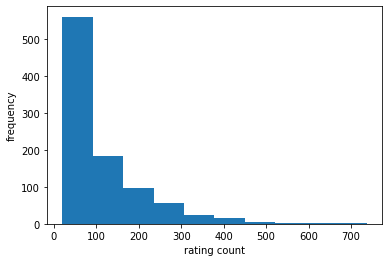

In [60]:
user_rating_count=np.count_nonzero(movie_matrix,axis=1)
plt.hist(user_rating_count)
plt.xlabel('rating count')
plt.ylabel('frequency')

**Answer for Q7(a)**

choose 200 as threshold.

In [0]:
def mod_uu_SimBasedRecSys(rating_matrix):
  similarity_matrix = 1 - pairwise_distances(rating_matrix, metric='cosine')
  temp_matrix = np.zeros(rating_matrix.shape)
  temp_matrix[rating_matrix.nonzero()] = 1
  normalizer = np.matmul(similarity_matrix, temp_matrix)
  normalizer[normalizer == 0] = 1e-5
  predictionMatrix = np.matmul(similarity_matrix, rating_matrix)/normalizer
  useraverage=np.sum(rating_matrix, axis=1)
  useraverage[useraverage!=0] = np.sum(rating_matrix[useraverage!=0], axis=1)/np.sum(temp_matrix[useraverage!=0], axis=1)
  columns = np.sum(predictionMatrix, axis=0)
  predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
  return predictionMatrix

In [0]:
def mod_ii_SimBasedRecSys(rating_matrix):
  similarity_matrix = 1 - pairwise_distances(rating_matrix.T, metric='cosine')
  temp_matrix = np.zeros(rating_matrix.shape)
  temp_matrix[rating_matrix.nonzero()] = 1
  normalizer = np.matmul(temp_matrix,similarity_matrix)
  normalizer[normalizer == 0] = 1e-5
  predictionMatrix = np.matmul(rating_matrix,similarity_matrix)/normalizer
  useraverage=np.sum(rating_matrix, axis=1)
  useraverage[useraverage!=0] = np.sum(rating_matrix[useraverage!=0], axis=1)/np.sum(temp_matrix[useraverage!=0], axis=1)
  columns = np.sum(predictionMatrix, axis=0)
  predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
  return predictionMatrix

In [0]:
# Train model with base datasets
base_filenames=['u1.base','u2.base','u3.base','u4.base','u5.base']
low_uu_prediction=[]
low_ii_prediction=[]
high_uu_prediction=[]
high_ii_prediction=[]

for i in range(5):
  base_filename=base_filenames[i]
  base_ratingDF=getData(MOVIELENS_DIR, base_filename)
  base_matrix=dataPreprocessor(base_ratingDF, num_users, num_items)
  base_user_rating_count=np.count_nonzero(base_matrix,axis=1)
  low_rating_userID=np.where(base_user_rating_count<=200)[0]
  high_rating_userID=np.where(base_user_rating_count>200)[0]

  low_cond=np.isin(base_ratingDF['userID'].values,low_rating_userID)
  high_cond=np.isin(base_ratingDF['userID'].values,high_rating_userID)
  low_ratingDF=base_ratingDF.copy()
  high_ratingDF=base_ratingDF.copy()
  low_ratingDF.iloc[high_cond,2]=0
  high_ratingDF.iloc[low_cond,2]=0

  low_matrix=base_matrix.copy()
  low_matrix[high_rating_userID]=0
  high_matrix=base_matrix.copy()
  high_matrix[low_rating_userID]=0

  # low uu prediction
  low_uu_prediction_matrix=mod_uu_SimBasedRecSys(low_matrix)
  low_uu_prediction_matrix_copy=low_uu_prediction_matrix.copy()
  low_uu_prediction_matrix[high_rating_userID]=base_matrix[high_rating_userID]
  low_uu_prediction.append(low_uu_prediction_matrix)

  # high uu prediction
  high_uu_prediction_matrix=mod_uu_SimBasedRecSys(high_matrix)
  high_uu_prediction_matrix_copy=high_uu_prediction_matrix.copy()
  high_uu_prediction_matrix[low_rating_userID]=base_matrix[low_rating_userID]
  high_uu_prediction.append(high_uu_prediction_matrix)

  # combined_uu_prediction
  # combined_uu_prediction_matrix=low_uu_prediction_matrix_copy+high_uu_prediction_matrix_copy

  # low_ii_prediction
  low_ii_prediction_matrix=mod_ii_SimBasedRecSys(low_matrix)
  low_ii_prediction_matrix_copy=low_ii_prediction_matrix.copy()
  low_ii_prediction_matrix[high_rating_userID]=base_matrix[high_rating_userID]
  low_ii_prediction.append(low_ii_prediction_matrix)

  # high uu prediction
  high_ii_prediction_matrix=mod_ii_SimBasedRecSys(high_matrix)
  high_ii_prediction_matrix_copy=high_ii_prediction_matrix.copy()
  high_ii_prediction_matrix[low_rating_userID]=base_matrix[low_rating_userID]
  high_ii_prediction.append(high_ii_prediction_matrix)


In [0]:
def rmse(pred, test):
    # calculate RMSE for all the items in the test dataset
    predItems = pred[test.nonzero()].flatten() 
    testItems = test[test.nonzero()].flatten()
    return sqrt(mean_squared_error(predItems, testItems))

In [0]:
# Test model with test dataset
low_uu_RMSE=[]
low_ii_RMSE=[]
high_uu_RMSE=[]
high_ii_RMSE=[]

for i in range(5):
  test_filenames=['u1.test','u2.test','u3.test','u4.test','u5.test']
  test_filename=test_filenames[i]
  test_ratingDF=getData(MOVIELENS_DIR, 'u2.test')
  test_matrix=dataPreprocessor(test_ratingDF, num_users, num_items)

  low_ii_prediction_matrix=low_ii_prediction[i]
  low_uu_prediction_matrix=low_uu_prediction[i]
  high_ii_prediction_matrix=high_ii_prediction[i]
  high_uu_prediction_matrix=high_uu_prediction[i]
  
  low_uu_RMSE.append(rmse(low_uu_prediction_matrix,test_matrix))
  low_ii_RMSE.append(rmse(low_ii_prediction_matrix,test_matrix))
  high_uu_RMSE.append(rmse(high_uu_prediction_matrix,test_matrix))
  high_ii_RMSE.append(rmse(high_ii_prediction_matrix,test_matrix))

In [66]:
result_df=pd.DataFrame(
    data=[low_uu_RMSE,low_ii_RMSE,high_uu_RMSE,high_ii_RMSE],
    index=['low_uu_RMSE','low_ii_RMSE','high_uu_RMSE','high_ii_RMSE'],
    columns=['u1.test','u2.test','u3.test','u4.test','u5.test']
)
result_df['average']=result_df.mean(axis=1)
result_df

,u1.test,u2.test,u3.test,u4.test,u5.test,average
low_uu_RMSE,0.752467,2.017495,0.745715,0.716443,0.705866,0.987597
low_ii_RMSE,0.770075,2.015953,0.759895,0.728632,0.719538,0.998819
high_uu_RMSE,0.495925,3.288844,0.513535,0.562000,0.579329,1.087926
high_ii_RMSE,0.560338,3.286760,0.585667,0.632513,0.645116,1.142079


**Answer for Q7(a)**

The low user RMSE is lower. The reason is that the "low" category have much more users than the "high" category. Therefore, when implementing similarity analysis, more users lead to more data and also a more accurate model.

# Validation

In [0]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [0]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [0]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [0]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validatePopularityRecSys()

### User Average Based Recommendation

In [0]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateUserAverRecSys()

## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [0]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [0]:
# 2 way smilarity: user-user similarity & item-item similarity
# user-user similarity dim: u^2
# item-item similarity dim: i^2

# select top k similar user/item

# predictionmatrix dim: u*i

In [0]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [0]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [0]:
validateCustomizedSim()

### User-User Similarity Based Recommendation System

In [0]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateUUSimBasedRecSys()

### Item-Item Similarity Based Recommendation System

In [0]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateIISimBasedRecSys()

### Probabilistic Matrix Factorization Recommendation System

In [0]:
def validatePMFRecSys(validation_df=validation_df):
    try:
        pmf = PMFRecSys()
        pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 1, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
        pmf.predict_all(rating_df, ROW_NUM, COL_NUM)
    except:
        print("Got error when instantiate PMFRecSys")
        return
    
    try:
        pmf.predict_all(validation_df, ROW_NUM, COL_NUM)
        W_item, W_user = pmf.w_Item, pmf.w_User
        assert(W_item.shape == (COL_NUM+1, 10) and W_user.shape == (ROW_NUM+1, 10)),\
        "Shape of w_Item and W_User doesn't match predefined shape"
    except Exception as e:
        print(e)

In [0]:
validatePMFRecSys(validation_df=validation_df)